In [1]:
# LSTM Prediction

In [8]:
!pip install --upgrade statsmodels



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


[*********************100%%**********************]  1 of 1 completed


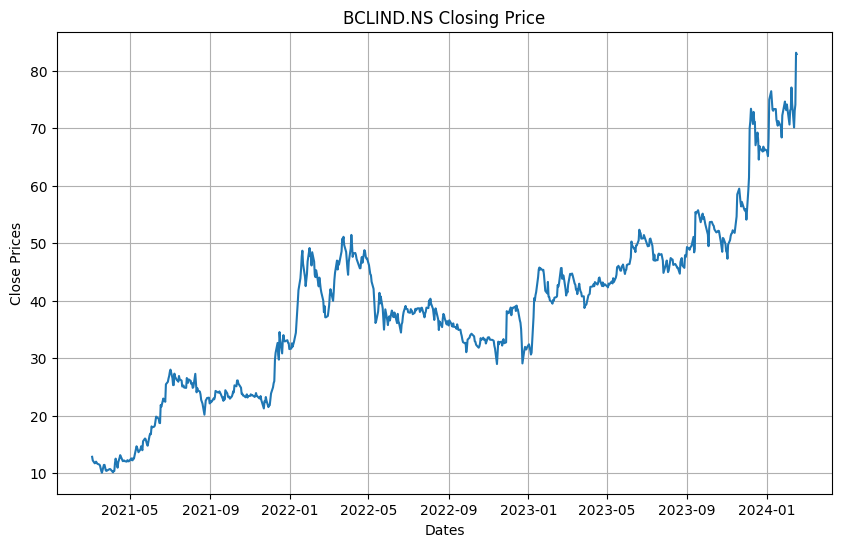

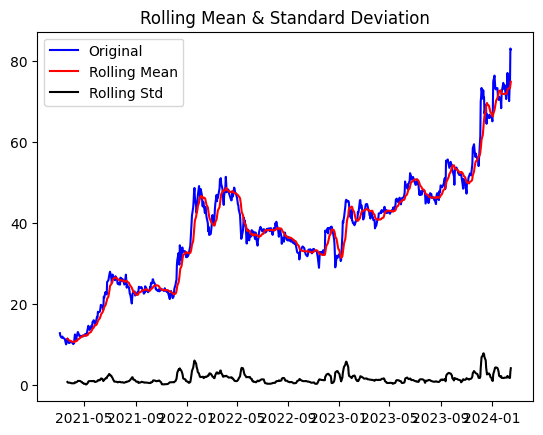

Results of Dickey Fuller Test
Test Statistics                 -0.062595
p-value                          0.953039
No. of lags used                 3.000000
Number of observations used    727.000000
critical value (1%)             -3.439377
critical value (5%)             -2.865524
critical value (10%)            -2.568891
dtype: float64


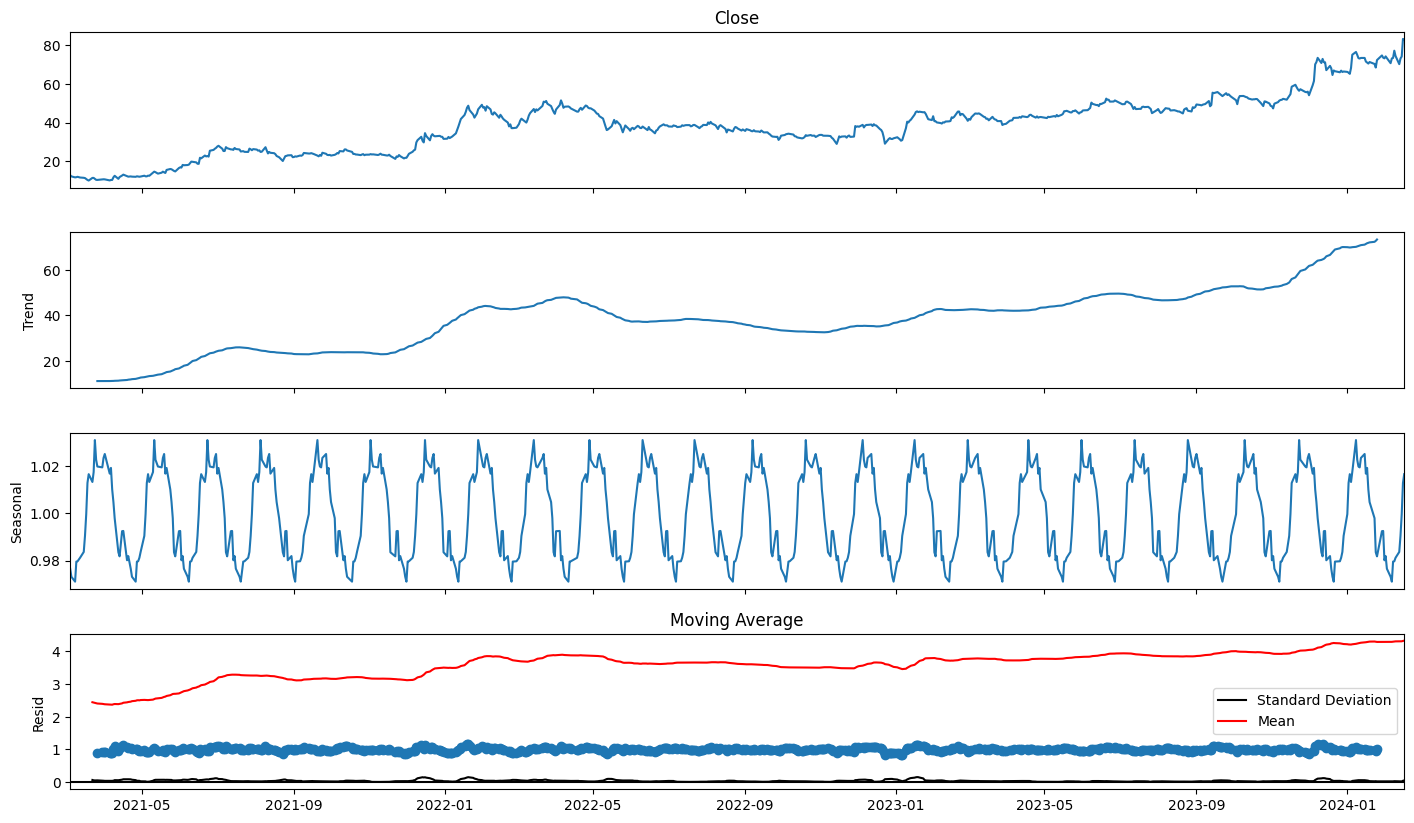

/home/tikam/stock-market/env3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/tikam/stock-market/env3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/tikam/stock-market/env3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


TypeError: ARIMA.fit() got an unexpected keyword argument 'disp'

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
import datetime  
import math

# Define the ticker and date range
ticker = "BCLIND.NS"
start_date = datetime.datetime.now() - datetime.timedelta(days=3650)
end_date = datetime.date.today()

# Fetch data using yfinance
data = yf.download(ticker, start=start_date, end=end_date)

# Plot the closing price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title(f"{ticker} Closing Price")
plt.show()

# Test for stationarity
def test_stationarity(timeseries):
    # Rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller Test
    print("Results of Dickey Fuller Test")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output[f'critical value ({key})'] = value
    print(output)

test_stationarity(data['Close'])

# Decompose the series
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)
fig = result.plot()  
fig.set_size_inches(16, 9)

# Log transform
df_log = np.log(data['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

# Plot moving average
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.plot(moving_avg, color='red', label='Mean')
plt.legend()
plt.title('Moving Average')
plt.show()

# Split data into train and test sets
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

# Build and fit ARIMA model
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)

# Plot forecast
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training')
plt.plot(test_data, color='blue', label='Actual Price')
plt.plot(fc_series, color='orange', label='Predicted Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Performance metrics
mse = mean_squared_error(test_data, fc)
mae = mean_absolute_error(test_data, fc)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

# Auto ARIMA
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, test='adf', max_p=3, max_q=3, m=1, d=None, seasonal=False, start_P=0, D=0, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()
